Universidad del Valle de Guatemala  
Departamento de Ciencias de la Computación  
Inteligencia Artificial - sección 10  

Laboratorio 4

Nadissa Vela - 23764  
Cristian Túnchez - 231359

---

# Task 2.2 - Perceptrón de Una Capa

**Importar librerías**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris  # Solo para cargar datos

## 1. Dataset

### a. Cargar dataset Iris y seleccionar 2 clases

In [15]:
# Cargar el dataset Iris
iris = load_iris()
X_full = iris.data
y_full = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

print("Dataset cargado")
print(f"Features: {feature_names}")
print(f"Clases: {class_names}")
print(f"Shape completo: X={X_full.shape}, y={y_full.shape}")

Dataset cargado
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Clases: ['setosa' 'versicolor' 'virginica']
Shape completo: X=(150, 4), y=(150,)


### b. Seleccionar solo 2 clases para clasificación binaria

In [16]:
# Seleccionar Setosa vs Versicolor, clases linealmente separables
class_0 = 0  # Setosa
class_1 = 1  # Versicolor

# Filtrar las clases
mask = (y_full == class_0) | (y_full == class_1)
X_binary = X_full[mask]
y_binary = y_full[mask]

print(f"\nClases seleccionadas {class_names[class_0]} vs {class_names[class_1]}")
print(f"Shape del dataset binario: X={X_binary.shape}, y={y_binary.shape}")
print(f"Distribución de clases: {class_names[class_0]}={np.sum(y_binary==0)}, {class_names[class_1]}={np.sum(y_binary==1)}")


Clases seleccionadas setosa vs versicolor
Shape del dataset binario: X=(100, 4), y=(100,)
Distribución de clases: setosa=50, versicolor=50


### c. Seleccionar solo 2 features para visualización en 2D

In [17]:
# Seleccionar sepal length y sepal width
feature_idx = [0, 1]
X = X_binary[:, feature_idx]
y = y_binary

selected_features = [feature_names[i] for i in feature_idx]

print(f"\nFeatures {selected_features}")
print(f"Shape final: X={X.shape}, y={y.shape}")
print(f"\nEstadísticas de X:")
print(f"  - {selected_features[0]}: min={X[:, 0].min():.2f}, max={X[:, 0].max():.2f}, mean={X[:, 0].mean():.2f}")
print(f"  - {selected_features[1]}: min={X[:, 1].min():.2f}, max={X[:, 1].max():.2f}, mean={X[:, 1].mean():.2f}")


Features ['sepal length (cm)', 'sepal width (cm)']
Shape final: X=(100, 2), y=(100,)

Estadísticas de X:
  - sepal length (cm): min=4.30, max=7.00, mean=5.47
  - sepal width (cm): min=2.00, max=4.40, mean=3.10


**Visualizar los datos**

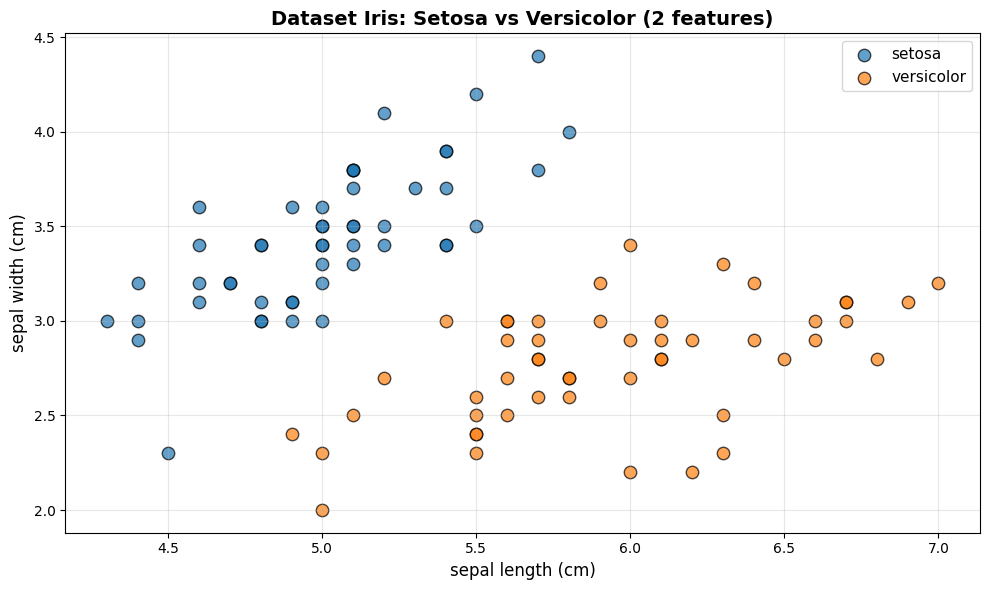


¿Los datos parecen linealmente separables?


In [18]:
# Visualizar los datos en 2D
plt.figure(figsize=(10, 6))

# Plotear cada clase con diferente color
for class_idx in [class_0, class_1]:
    mask = y == class_idx
    plt.scatter(X[mask, 0], X[mask, 1], 
                label=class_names[class_idx],
                s=80, alpha=0.7, edgecolors='black', linewidth=1)

plt.xlabel(selected_features[0], fontsize=12)
plt.ylabel(selected_features[1], fontsize=12)
plt.title('Dataset Iris: Setosa vs Versicolor (2 features)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n¿Los datos parecen linealmente separables?")

## 2. Implementación del Perceptrón

### Clase Perceptron

In [19]:
class Perceptron:
    """
    Implementación del algoritmo Perceptrón 
    
    Utilizamos la función: w1*x1 + w2*x2 + b = 0
    
    Args:
        learning_rate: qué tan grandes son los cambios en los pesos
        n_iterations: veces se recorre el dataset 
        random_seed: semilla para reproducibilidad 
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=100, random_seed=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_seed = random_seed
        
        # Pesos y bias (se inicializarán en fit)
        self.weights = None
        self.bias = None
        
        # Historia del entrenamiento
        self.history = {
            'errors': [],
            'weights': [],
            'bias': []
        }
    
    def _initialize_weights(self, n_features):
        """
        Inicializa los pesos y bias aleatoriamente, como indica la diapositiva 48 
        de la presentación
        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        
        # Inicializar pesos con valores pequeños aleatorios
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = np.random.randn() * 0.01
    
    def _activation_function(self, z):
        """
        Función de activación Step
        
        Si z >= 0, retorna 1
        Si z < 0, retorna 0
        
        """
        return np.where(z >= 0, 1, 0)
    
    def _compute_output(self, X):
        """
        Feedforward del perceptrón 
        
        1. Calculamos la suma ponderada: z = w·x + b
        2. Aplicamos función de activación: y = step(z)
        
        Args:
            X: matriz de características (n_samples, n_features)
        
        Returns:
            y_pred: predicciones (n_samples,)
        """
        # Paso 1: Suma ponderada (producto punto)
        z = np.dot(X, self.weights) + self.bias
        
        # Paso 2: Función de activación
        y_pred = self._activation_function(z)
        
        return y_pred
    
    def fit(self, X, y, verbose=True):
        """
        Entrena el perceptrón usando la regla de actualización
        
        Regla de actualización:
        Para cada muestra (x_i, y_i):
            1. Calculamos la predicción: y_pred = step(w·x + b)
            2. Calculamos el error: error = y_true - y_pred
            3. Actualizamos pesos: w = w + η * error * x
            4. Actualizamos bias: b = b + η * error
        
        El perceptrón converge si los datos son linealmente separables
        
        Args:
            X: matriz de características (n_samples, n_features)
            y: vector de etiquetas (n_samples,)
            verbose: imprime información durante el entrenamiento
        
        Returns:
            self
        """
        n_samples, n_features = X.shape
        
        # Inicializar pesos y bias aleatoriamente
        self._initialize_weights(n_features)
        
        if verbose:
            print("\n")
            print("ENTRENAMIENTO DEL PERCEPTRÓN")
            print(f"Configuración:")
            print(f"  - Learning rate: {self.learning_rate}")
            print(f"  - Max iterations: {self.n_iterations}")
            print(f"  - Pesos iniciales: {self.weights}")
            print(f"  - Bias inicial: {self.bias:.4f}")
            print()
        
        # Iterar por epochs
        for iteration in range(self.n_iterations):
            errors = 0
            
            # Iterar por cada muestra (aprendizaje online)
            for i in range(n_samples):
                # Obtener una muestra
                x_i = X[i]
                y_i = y[i]
                
                # 1. Feedforward: calcular predicción
                y_pred_i = self._compute_output(x_i.reshape(1, -1))[0]
                
                # 2. Calcular error
                error = y_i - y_pred_i
                
                # 3. Actualizar pesos si hay error
                if error != 0:
                    # Regla de actualización del perceptrón
                    self.weights += self.learning_rate * error * x_i
                    self.bias += self.learning_rate * error
                    errors += 1
            
            # Guardar historia
            self.history['errors'].append(errors)
            self.history['weights'].append(self.weights.copy())
            self.history['bias'].append(self.bias)
            
            # Imprimir progreso
            if verbose and (iteration % 10 == 0 or iteration == self.n_iterations - 1):
                accuracy = (n_samples - errors) / n_samples
                print(f"Epoch {iteration:3d}: Errores = {errors:2d}, Accuracy = {accuracy:.4f}")
            
            # Convergencia: si no hay errores, el perceptrón convergió
            if errors == 0:
                if verbose:
                    print(f"\n¡Convergencia alcanzada en epoch {iteration}!")
                    print("El perceptrón clasificó correctamente todos los datos.")
                break
        
        if verbose:
            print("\n")
            print("ENTRENAMIENTO COMPLETADO")
            print(f"Pesos finales: {self.weights}")
            print(f"Bias final: {self.bias:.4f}")
            print(f"Ecuación de la frontera: {self.weights[0]:.4f}*x1 + {self.weights[1]:.4f}*x2 + {self.bias:.4f} = 0")
        
        return self
    
    def predict(self, X):
        """
        Predice las etiquetas para nuevas muestras
        
        Args:
            X: matriz de características (n_samples, n_features)
        
        Returns:
            y_pred: predicciones (n_samples,)
        """
        if self.weights is None:
            raise Exception("El modelo no ha sido entrenado. Llama a .fit() primero.")
        
        return self._compute_output(X)
    
    def get_decision_boundary(self):
        """
        Retorna los parámetros de la frontera de decisión
        
        La frontera de decisión es la línea: w1*x1 + w2*x2 + b = 0
        Reescrita como: x2 = -(w1/w2)*x1 - (b/w2)
        
        Returns:
            slope: pendiente de la línea
            intercept: intersección con el eje y
        """
        if self.weights[1] != 0:
            slope = -self.weights[0] / self.weights[1]
            intercept = -self.bias / self.weights[1]
            return slope, intercept
        else:
            # Línea vertical
            return None, -self.bias / self.weights[0]

print("Clase Perceptron implementada correctamente.")

Clase Perceptron implementada correctamente.


## 3. Visualización y Métricas

### a. Entrenar el modelo

In [20]:
# Crear y entrenar el perceptrón
perceptron = Perceptron(learning_rate=0.1, n_iterations=100, random_seed=42)
perceptron.fit(X, y, verbose=True)



ENTRENAMIENTO DEL PERCEPTRÓN
Configuración:
  - Learning rate: 0.1
  - Max iterations: 100
  - Pesos iniciales: [ 0.00496714 -0.00138264]
  - Bias inicial: 0.0065

Epoch   0: Errores =  2, Accuracy = 0.9800
Epoch  10: Errores =  2, Accuracy = 0.9800
Epoch  20: Errores =  2, Accuracy = 0.9800
Epoch  30: Errores =  2, Accuracy = 0.9800
Epoch  40: Errores =  3, Accuracy = 0.9700
Epoch  50: Errores =  2, Accuracy = 0.9800
Epoch  60: Errores =  2, Accuracy = 0.9800
Epoch  70: Errores =  2, Accuracy = 0.9800
Epoch  80: Errores =  3, Accuracy = 0.9700
Epoch  90: Errores =  2, Accuracy = 0.9800
Epoch  99: Errores =  2, Accuracy = 0.9800


ENTRENAMIENTO COMPLETADO
Pesos finales: [ 4.06496714 -5.68138264]
Bias final: -2.3935
Ecuación de la frontera: 4.0650*x1 + -5.6814*x2 + -2.3935 = 0


### b. Frontera de Decisión

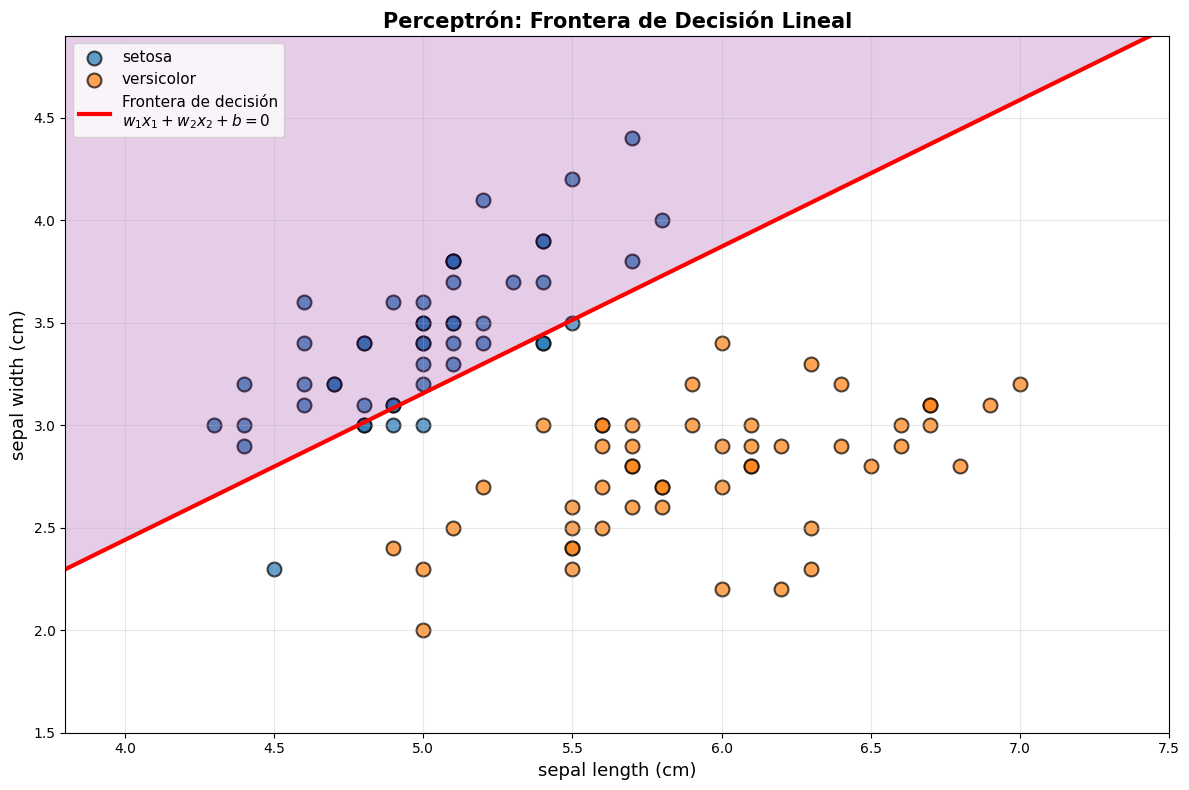


Ecuación de la frontera de decisión:
  4.0650 * sepal length (cm) + -5.6814 * sepal width (cm) + -2.3935 = 0

Forma explícita:
  sepal width (cm) = 0.7155 * sepal length (cm) + -0.4213


In [21]:
def plot_decision_boundary(X, y, perceptron, class_names, feature_names):
    """
    Grafica los datos y la frontera de decisión aprendida por el perceptrón
    
    La frontera de decisión es la línea: w1*x1 + w2*x2 + b = 0
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plotear los datos por clase
    for class_idx in np.unique(y):
        mask = y == class_idx
        ax.scatter(X[mask, 0], X[mask, 1],
                  label=class_names[class_idx],
                  s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Dibujar la frontera de decisión
    slope, intercept = perceptron.get_decision_boundary()
    
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x1_line = np.array([x1_min, x1_max])
    
    if slope is not None:
        x2_line = slope * x1_line + intercept
        ax.plot(x1_line, x2_line, 'r-', linewidth=3, 
               label=f'Frontera de decisión\n$w_1x_1 + w_2x_2 + b = 0$')
        
        # Añadir región de decisión con sombreado
        x1_fill = np.linspace(x1_min, x1_max, 100)
        x2_fill = slope * x1_fill + intercept
        
        ax.fill_between(x1_fill, x2_fill, x1_max * 2, alpha=0.1, color='red')
        ax.fill_between(x1_fill, x1_min * 2, x2_fill, alpha=0.1, color='blue')
    
    # Etiquetas y formato
    ax.set_xlabel(feature_names[0], fontsize=13)
    ax.set_ylabel(feature_names[1], fontsize=13)
    ax.set_title('Perceptrón: Frontera de Decisión Lineal', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Establecer límites
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir ecuación de la frontera
    w1, w2 = perceptron.weights
    b = perceptron.bias
    print("\nEcuación de la frontera de decisión:")
    print(f"  {w1:.4f} * {feature_names[0]} + {w2:.4f} * {feature_names[1]} + {b:.4f} = 0")
    print(f"\nForma explícita:")
    if slope is not None:
        print(f"  {feature_names[1]} = {slope:.4f} * {feature_names[0]} + {intercept:.4f}")

# Graficar
plot_decision_boundary(X, y, perceptron, class_names, selected_features)

### c. Calcular y reportar Accuracy

In [22]:
# Hacer predicciones
y_pred = perceptron.predict(X)

# Calcular accuracy manualmente (sin sklearn)
accuracy = np.mean(y_pred == y)

# Crear matriz de confusión manualmente
true_positives = np.sum((y == 1) & (y_pred == 1))
true_negatives = np.sum((y == 0) & (y_pred == 0))
false_positives = np.sum((y == 0) & (y_pred == 1))
false_negatives = np.sum((y == 1) & (y_pred == 0))

confusion_matrix = np.array([
    [true_negatives, false_positives],
    [false_negatives, true_positives]
])

print("\n")
print("MÉTRICAS DE RENDIMIENTO")
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nMuestras correctamente clasificadas: {np.sum(y_pred == y)} / {len(y)}")
print(f"Muestras incorrectamente clasificadas: {np.sum(y_pred != y)} / {len(y)}")

print("\nMatriz de Confusión:")
print("                 Predicho")
print(f"                 {class_names[class_0]:12s} {class_names[class_1]:12s}")
print(f"Real {class_names[class_0]:12s} {true_negatives:12d} {false_positives:12d}")
print(f"     {class_names[class_1]:12s} {false_negatives:12d} {true_positives:12d}")

# Calcular métricas adicionales
if (true_positives + false_positives) > 0:
    precision = true_positives / (true_positives + false_positives)
else:
    precision = 0

if (true_positives + false_negatives) > 0:
    recall = true_positives / (true_positives + false_negatives)
else:
    recall = 0

if (precision + recall) > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nMétricas adicionales:")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - F1-Score: {f1_score:.4f}")



MÉTRICAS DE RENDIMIENTO

Accuracy: 0.9200 (92.00%)

Muestras correctamente clasificadas: 92 / 100
Muestras incorrectamente clasificadas: 8 / 100

Matriz de Confusión:
                 Predicho
                 setosa       versicolor  
Real setosa                 42            8
     versicolor              0           50

Métricas adicionales:
  - Precision: 0.8621
  - Recall: 1.0000
  - F1-Score: 0.9259


### Visualizar la evolución del entrenamiento

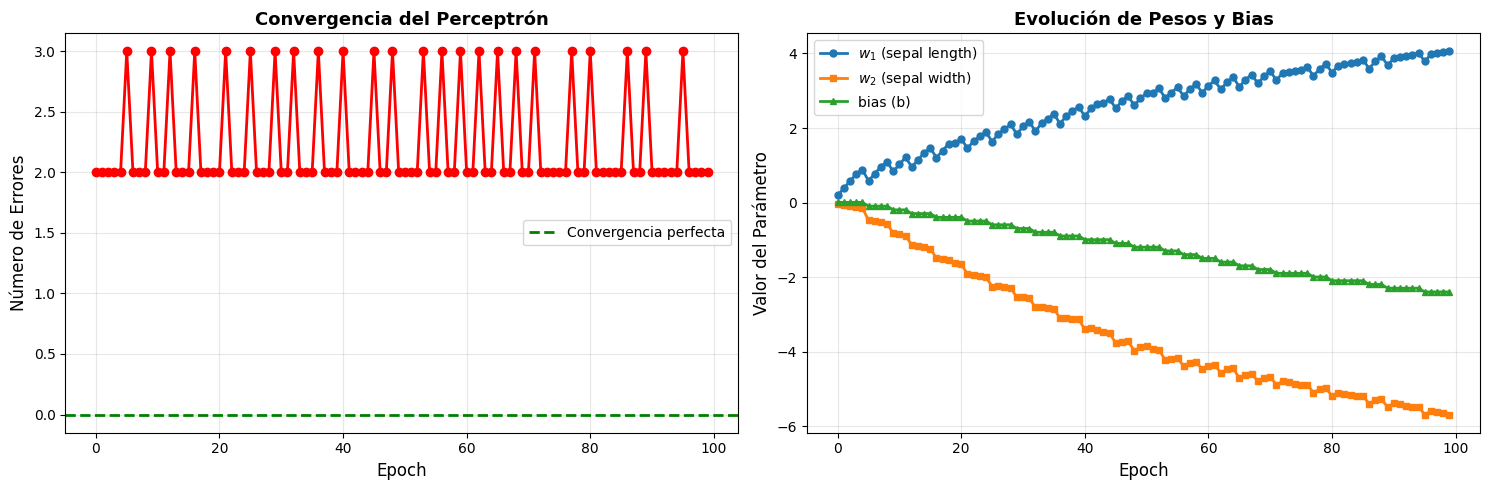


El perceptrón convergió en 100 epochs.


In [23]:
# Graficar la evolución del número de errores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Errores por epoch
ax1 = axes[0]
epochs = range(len(perceptron.history['errors']))
ax1.plot(epochs, perceptron.history['errors'], 'o-', linewidth=2, markersize=6, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Número de Errores', fontsize=12)
ax1.set_title('Convergencia del Perceptrón', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='green', linestyle='--', linewidth=2, label='Convergencia perfecta')
ax1.legend()

# Subplot 2: Evolución de los pesos
ax2 = axes[1]
weights_history = np.array(perceptron.history['weights'])
bias_history = np.array(perceptron.history['bias'])

ax2.plot(epochs, weights_history[:, 0], 'o-', label='$w_1$ (sepal length)', linewidth=2, markersize=5)
ax2.plot(epochs, weights_history[:, 1], 's-', label='$w_2$ (sepal width)', linewidth=2, markersize=5)
ax2.plot(epochs, bias_history, '^-', label='bias (b)', linewidth=2, markersize=5)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Valor del Parámetro', fontsize=12)
ax2.set_title('Evolución de Pesos y Bias', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEl perceptrón convergió en {len(perceptron.history['errors'])} epochs.")

## Análisis y Conclusiones

---


El perceptrón logró un accuracy de 92%, lo que significa que clasificó correctamente 92 de las 100 muestras, cometiendo 8 errores.

¿Por qué no es 100% perfecto?

Con las features seleccionadas (sepal length y sepal width), las clases Setosa y Versicolor no son totalmente separables linealmente. Existe un solapamiento entre las distribuciones de ambas clases en este espacio bidimensional. Una línea recta puede separar la mayoría de los puntos, pero algunos quedan mal clasificados debido a que las características de ciertas flores se encuentran en la región de ambigüedad entre las dos clases.

Además, el algoritmo de perceptrón simple solo puede aprender fronteras de decisión lineales. Puede fallar si los datos tienen overlapping entre clases o distribuciones que no son completamente separables linealmente.

El resultado depende de qué características usamos, aunque con los features actuales obtuvimos 92% de accuracy, si escogieramos petal length y petal width puede ser que obtengamos un resultado mejor.

Para obtener mejores resultados se podría implementar un perceptróon multicapa o implementar funciones de activación no lineales (ReLU o sigmoid).

**Conclusión:**

El 92% de accuracy demuestra que el perceptrón simple funciona bastantne bien con estos datos. Algunas flores tienen características muy similares entre Setosa y Versicolor cuando solo observamos largo y ancho del sépalo, lo que causa confusión en la clasificación.

---